# SastaGPT

### Introduction

In this notebook, I have implemented a Transformer, `SastaGPT`, from scratch based on the paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762) by Vaswani et al. (2017). I then trained this Transformer on a language modeling task on a dataset of my own choosing.

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

!pip install cohere
!pip install openai
!pip install tiktoken
import tiktoken

from google.colab import drive                                          # If not using Google Colab,
drive.mount("/content/drive")                                           # comment out these lines

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Creating a Dataset [20 Marks]

In this section, I created a dataset for training your Transformer. For this notebook, I used the [Cars 2 script on IMSDB](https://imsdb.com/scripts/Cars-2.html).

In [35]:
BATCH_SIZE = 32
BLOCK_SIZE = 8

# Create tiktoken object
encoder = tiktoken.get_encoding("gpt2")

# I chose Cars 2 as it was one of the movies I watched a thousand times as a kid (I knew the entire script by heart at one
# point and could just pass 2 hours remembering the whole movie in my head if I wanted to). I'd otherwise be pretty sad about
# the fact that most people don't like it because there isn't much of McQueen, but hey I don't really care XD.
with open("Cars 2.txt", "r", encoding="utf-8") as file:
    dataset = file.read()

encoded_ids = encoder.encode(dataset)           # Create the encoded ids using the encoder

def get_batch():
    '''
    Returns a batch (x, y) from the dataset
    '''
    # Get random integers for indexing into the dataset to create a batch
    start_i = np.random.randint(0, len(encoded_ids) - BLOCK_SIZE - 1, size=BATCH_SIZE)

    # Get the x and y (input and target) batches after encoding and indexing
    x = [encoded_ids[i : i + BLOCK_SIZE] for i in start_i]          # Get batch of x
    y = [encoded_ids[i+1 : i + BLOCK_SIZE+1] for i in start_i]      # Get batch of y (shifted ahead of x by 1)

    # Make sure these are int64 (long) tensors
    x = torch.tensor(x, dtype=int)
    y = torch.tensor(y, dtype=int)

    return x, y

xb, yb = get_batch()
xb.shape, yb.shape

(torch.Size([32, 8]), torch.Size([32, 8]))

## Creating the Transformer

### Defining our Hyperparameters [0 Marks]

We will define our hyperparameters here. You can play around with these later to see how they affect your model.

Since there are lots of hyperparameters to keep track of, it is easier for us to wrap all of them inside a `dataclass`. This can be passed around very easily to different functions, and makes it easier to keep track of all relevant values.

To quickly describe some of the hyperparameters:

1. `block_size`: This is the length of the sequence that we will be feeding into our model. This has also been called the *context length* and *window size* in other places.

2. `emb_dim`: This is the dimensionality of the embeddings we will have inside the model. This has implications on the outputs of tensors throughout the entire model.

3. `head_size`: When dealing with Multi-Head Attention, we will be *splitting* our embeddings into multiple heads. This is the size of each of those heads. For example, if we had an embedding of size 512, and we wanted 8 heads, then each head would have a size of 64. Down the line, we'd be concatenating these heads together, so the final output would be of size 512 again, as you should recall from the lectures.

4. `num_heads`: This is the number of attention heads we will have in our Multi-Head Attention layer.

5. `num_layers`: This is the number of layers we will have in our Transformer (this includes the MHSA, the Feedforward module, and the Layer Normalizations).

6. `vocab_size`: This is the size of our vocabulary. This is the number of unique tokens we have in our vocabulary. If you were to use character-level tokenization, this would be the number of unique characters in your dataset. Since you should be using subword-level tokenization, this will be the number of unique subwords in your dataset.

In [36]:
from dataclasses import dataclass

@dataclass
class Config:
    block_size: int = BLOCK_SIZE
    emb_dim: int = 256
    head_size: int = 32
    num_heads: int = 8
    num_layers: int = 2
    vocab_size: int = encoder.n_vocab # vocab size of the tokenizer

# We like to have emb_dim == head_size * num_heads
config = Config()
assert config.emb_dim == config.head_size * config.num_heads, "Embedding dimension must be divisible by number of heads"

### Multi-Head Self-Attention [20 Marks]

This component is the core of the Transformer. This is where the model learns to attend to different parts of the input sequence, and is the reason why Transformers are so powerful.

$$\text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$$

$$\text{head}_k = \text{Attention}(QW^Q_k, KW^K_k, VW^V_k)$$

$$\text{MHSA}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O$$

For simplicity, assume we have a single Head:

1. The input has three parts extracted from it: the query $Q$, the key $K$, and the value $V$ (via projections or `Linear` layers).

2. The query and key are multiplied together to get a score. This score is then scaled by the square root of the embedding dimension, $\sqrt{d_k}$, then passed through a softmax to get the attention weights (*after* a masking operation is applied).

3. The attention weights are then multiplied with the value to get the final output.

When we extend this to *multiple heads*, we simply repeat this process for each head in parallel, and then concatenate the outputs of each head together.

I created a class for this `MHSA` module (Multi-Head Self-Attention), adding a comment next to each line in the `forward` method for the shape of the tensor at that point.

In [37]:
class MHSA(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.emb_dim = cfg.emb_dim
        self.head_size = cfg.head_size
        self.block_size = cfg.block_size
        self.num_heads = cfg.num_heads

        # Define the single projection layer for QKV
        self.projection_QKV = nn.Linear(self.emb_dim, 3*self.emb_dim, bias=False)

        # Define the output projection layer
        self.projection_O = nn.Linear(self.emb_dim, self.emb_dim, bias=False)

        # Create a buffer for the mask (buffers are tensors that are not updated during backpropagation)
        self.register_buffer("mask", torch.tril(torch.ones(self.block_size, self.block_size)))

    def forward(self, x):

        B, T, C = x.shape # batch size, block size, emb dim
        H = self.num_heads

        # Carry out the projections to get the query, key and value - you may want to reshape them to (B, H, T, head_size) to make things easier
        QKV = self.projection_QKV(x)
        Q, K, V = QKV.split(C, dim=-1)

        Q = Q.reshape(B, H, T, C // H)
        K = K.reshape(B, H, T, C // H)
        V = V.reshape(B, H, T, C // H)

        # Compute the attention scores, perform masking, and apply the softmax
        attention_scores = Q @ K.transpose(-2, -1) / np.sqrt(C // H)
        attention_scores = attention_scores.masked_fill(self.mask[:T, :T] == 0, float("-inf"))
        attention_weights = F.softmax(attention_scores, dim=-1)

        # Compute the weighted sum of the value vectors - you can perform the concatenation via a simple reshaping before applying the final projection
        out = attention_weights @ V
        out = out.view(B, T, C)
        out = self.projection_O(out)

        return out

# !DO NOT REMOVE THESE LINES!
x = torch.randn(32, config.block_size, config.emb_dim)
print(x.shape)
csa = MHSA(config)
out = csa(x)
print(out.shape)

torch.Size([32, 8, 256])
torch.Size([32, 8, 256])


### Feedforward Network [10 Marks]

The Feedforward Network module usually consists of two linear layers, with a ReLU activation in between. The first linear layer projects the input's Embeddings to a higher dimensionality (by a factor of 4 specifically), and the second linear layer projects it back down to the original dimensionality. This is a very simple module, but is very effective in learning complex functions.

I created a class for this `Feedforward` module, with the following tweaks:

1. Used the [GELU Activation Function](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) instead of ReLU between the layers. It is functionally very similar, but has gained a lot of popularity recently.

2. Instead of using two `Linear` layers, and an upsampling factor of `4`, used **three** `Linear` layers: the first one upsamples by a factor of `2`, the second one does not change the dimensionality, and the third one downsamples by a factor of `2`. This creates a slightly deeper network, and can be shown to have the same number of parameters as the network in the original Transformer.

3. Added a [Dropout layer](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) after the last `Linear` layer, with $p=0.1$. This helps mitigate overfitting.

In [38]:
class Feedforward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.emb_dim = config.emb_dim

        # Define the feedforward network
        self.feedforward = nn.Sequential(
            nn.Linear(self.emb_dim, self.emb_dim * 2),
            nn.GELU(),
            nn.Linear(self.emb_dim * 2, self.emb_dim * 2),
            nn.GELU(),
            nn.Linear(self.emb_dim * 2, self.emb_dim),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        # Apply the feedforward network
        x = self.feedforward(x)
        return x

### Blocks with Skip Connections [10 Marks]

The Encoder consists of multiple *Blocks*, that each contain a Multi-Head Self-Attention module, a Feedforward module, and a Layer Normalization module. We use Skip Connections to help with the flow of gradients during the training process.

I created a class for this `Block` module, with the following tweaks:

- Instead of creating your own Layer Normalization module, used [the one provided by PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html), `nn.LayerNorm`.

- Perform the Layer Normalizations **before** the Skip Connections, instead of after. The original paper used the "post-LN" approach, but [recent research](https://arxiv.org/abs/2002.04745) has shown that the "pre-LN" approach is better.

In [39]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()

        # Define the MHSA, Feedforward, and two LayerNorm modules
        self.mhsa = MHSA(config)
        self.feedforward = Feedforward(config)
        self.norm1 = nn.LayerNorm(config.emb_dim)
        self.norm2 = nn.LayerNorm(config.emb_dim)

    def forward(self, x):

        # Apply the modules with residual connections (use the Pre-LN design)
        x = x + self.mhsa(self.norm1(x))
        x = x + self.feedforward(self.norm2(x))
        return x

x = torch.randn(8, config.block_size, config.emb_dim)
print(x.shape)
block = Block(config)
out = block(x)
print(out.shape)

torch.Size([8, 8, 256])
torch.Size([8, 8, 256])


### Putting it all together [20 Marks]

Now that we have all the components, we can put them together to create the Transformer. The Transformer consists of

1. Creating Embeddings for the input sequence. This implies turning the input sequence into a sequence of indices, and then passing it through an `nn.Embedding` layer. Alongside this, we will be using another Embedding table for the positional encodings. For simplicity, we can keep the embedding dimensionality for both of these the same.

2. Passing the embeddings through a series of Blocks.

3. Passing the output of the Encoder through a Layer Normalization layer, and then a Linear layer to get the final logits.

I created a class for this `SastaGPT` module (note: "Sasta" means "cheap"). This will be the final model that we will be training.

In [40]:
class SastaGPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.emb_dim = config.emb_dim
        self.block_size = config.block_size
        self.num_layers = config.num_layers
        self.vocab_size = config.vocab_size

        # Define the word and position embeddings
        # They will both have the same embedding dimension, only difference is the number of embeddings (vocab_size vs. block_size)
        self.word_embeddings = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.emb_dim)
        self.position_embeddings = nn.Embedding(num_embeddings=self.block_size, embedding_dim=self.emb_dim)

        # Define the sequence of Blocks
        self.blocks = nn.Sequential(*[Block(config) for _ in range(self.num_layers)])

        # Define the final LayerNorm
        self.final_layer_norm = nn.LayerNorm(self.emb_dim)

        # Define the final linear layer (to get logits)
        self.final_linear = nn.Linear(self.emb_dim, self.vocab_size)

        # Initialize the weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idxs):
        # idxs: (B, T)
        batch_size, seq_len = idxs.shape

        assert seq_len <= self.block_size, f"Sequence length exceeds block size of {self.block_size}"

        # Get the word embeddings (B, T, C) and position embeddings (T, C)
        # For the position embeddings, you can use torch.arange(seq_len) to mimic the indices
        # Note: position embeddings are encodings of the position indices (NOT the actual tokens)
        position_embeddings = self.position_embeddings(torch.arange(seq_len))
        word_embeddings = self.word_embeddings(idxs)

        # Add the word and position embeddings (broadcasting will take care of the shapes)
        x = word_embeddings + position_embeddings

        # Pass the embeddings through the blocks (B, T, C)
        x = self.blocks(x)

        # Apply the final LayerNorm
        x = self.final_layer_norm(x)

        # Apply the final linear layer to get the logits (B, T, V)
        logits = self.final_linear(x)

        return logits

    @torch.no_grad()
    def generate(self, idxs, max_new_tokens=20):
        '''
        Takes in a sequence of indices (the tokenized sentence) and generates new tokens
        Note that the input indices should not be longer than the block size
        Returns the input sequence with the generated tokens appended (these should be decoded using the Tokenizer)

        Params
        ------
        idxs: torch.Tensor
            (B, T) tensor of token indices
        max_new_tokens: int
            Maximum number of new tokens to generate
        '''

        # idxs: (B, T)
        for _ in range(max_new_tokens):
            idxs_trimmed = idxs[:, -self.block_size:] # trim to block size

            logits = self(idxs_trimmed) # (B, T, V)

            logits = logits[:, -1, :] # (B, V)

            probs = F.softmax(logits, dim=-1) # (B, V)

            next_idx = torch.multinomial(probs, num_samples=1) # (B, 1)

            idxs = torch.cat((idxs, next_idx), dim=1) # (B, T+1)

        return idxs

cfg = Config()
model = SastaGPT(cfg)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()) / 1e6 :.3f}M")

Number of parameters: 27.362M


In [41]:
# Check out the forward pass
xb, yb = get_batch()
print(xb.shape)

logits = model(xb)
print(logits.shape) # (B, T, V)

torch.Size([32, 8])
torch.Size([32, 8, 50257])


Now I trained this model on the Cars 2 script!

In [42]:
# Train the model
def train(model, optimizer, epochs=1500):
    train_loss = 0.0                                        # Start with a training loss of 0.0
    for epoch in range(epochs):                             # For each epoch,
        xb, yb = get_batch()                                # Get x batch and y batch
        model.train()                                       # Train the model
        logits = model(xb)                                  # logits contain B, T, and V
        B, T, V = logits.shape                              # Unpack to get B, T, and V
        logits = logits.view(B*T, V)                        # Reshape first two dims to get logits
        targets = yb.view(B*T)                              # Reshape to get targets
        optimizer.zero_grad()                               # Zero the parameter gradients
        loss = F.cross_entropy(logits, targets)             # Calculate loss
        loss.backward()                                     # Perform backward pass
        optimizer.step()                                    # Perform one optimization step
        train_loss += loss.item()                           # Return loss
        if epoch % 100 == 0 or epoch == epochs - 1:         # Log the loss
            print(f"Epoch {epoch} | Loss: {loss:.6f}")      # and print it each time the condition is met

model = SastaGPT(cfg)                                           # Create an instance of SastaGPT
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)     # Use Adam optimizer with a learning rate of 0.001
train(model, optimizer, epochs=1500)                            # Train model on 1500 epochs

Epoch 0 | Loss: 10.892176
Epoch 100 | Loss: 4.800010
Epoch 200 | Loss: 4.329611
Epoch 300 | Loss: 4.168261
Epoch 400 | Loss: 3.812385
Epoch 500 | Loss: 3.573731
Epoch 600 | Loss: 3.644112
Epoch 700 | Loss: 3.518056
Epoch 800 | Loss: 3.277060
Epoch 900 | Loss: 3.192430
Epoch 1000 | Loss: 2.804402
Epoch 1100 | Loss: 3.058885
Epoch 1200 | Loss: 2.855188
Epoch 1300 | Loss: 3.088579
Epoch 1400 | Loss: 2.963047
Epoch 1499 | Loss: 2.975035


With my trained model, I generated some text.

In [43]:
# Check out the generate method
sentence = " "
idxs = torch.tensor(encoder.encode(sentence)).unsqueeze(0)

model.eval()
generated = model.generate(idxs, max_new_tokens=100)
res = encoder.decode(generated[0].numpy())
print(res)

 .

QUEEN

MATER
Missile.

course! AXLEROD, Francesco exos on the bar.


Mater.
85.
MAMA TOPOLLEY

gum lemons are you.
MATER I was talking. He
Do you will find in the phone.
race lemons. I
Wait, sir.
impact of them, they shoves his rear end of thuggish HOBBS PAC


Note that the quality of the generated text depends on:

- How large the training dataset was. If you used a small dataset, your model will not have enough samples to learn the syntax, semantics, the grammar and other intricacies of language, much less the specifics of the dataset.

- How long you trained for. Provided your dataset was large enough, you could try training for longer epochs until the loss values stabilize.

- How large your model was. If you used a small model, it will not have enough parameters to learn the complexities of language. You can try increasing the number of layers, the embedding dimensionality, the number of heads, etc.

It wasn't anything super special or insane :(

But hey it was good enough :)

## Effects of Hyperparameters on the Number of Parameters [10 Marks]

In this section, we explored the effects of the hyperparameters on the number of parameters in our model.

With so much room for tweaking (with the embedding dimensionality, the size of the vocab, the number of heads, the number of layers, etc.), it is important to visualize how fast the total number of parameters can grow if you start toying with them.

In [44]:
def get_params(model):
    '''
    Returns the number of parameters in the model (in millions)
    '''
    return sum(p.numel() for p in model.parameters()) / 1e6

@dataclass
class Config:
    block_size: int = BLOCK_SIZE
    emb_dim: int = 256
    head_size: int = 32
    num_heads: int = 8
    num_layers: int = 2
    vocab_size: int = 100 # smaller vocab size for quick prototyping

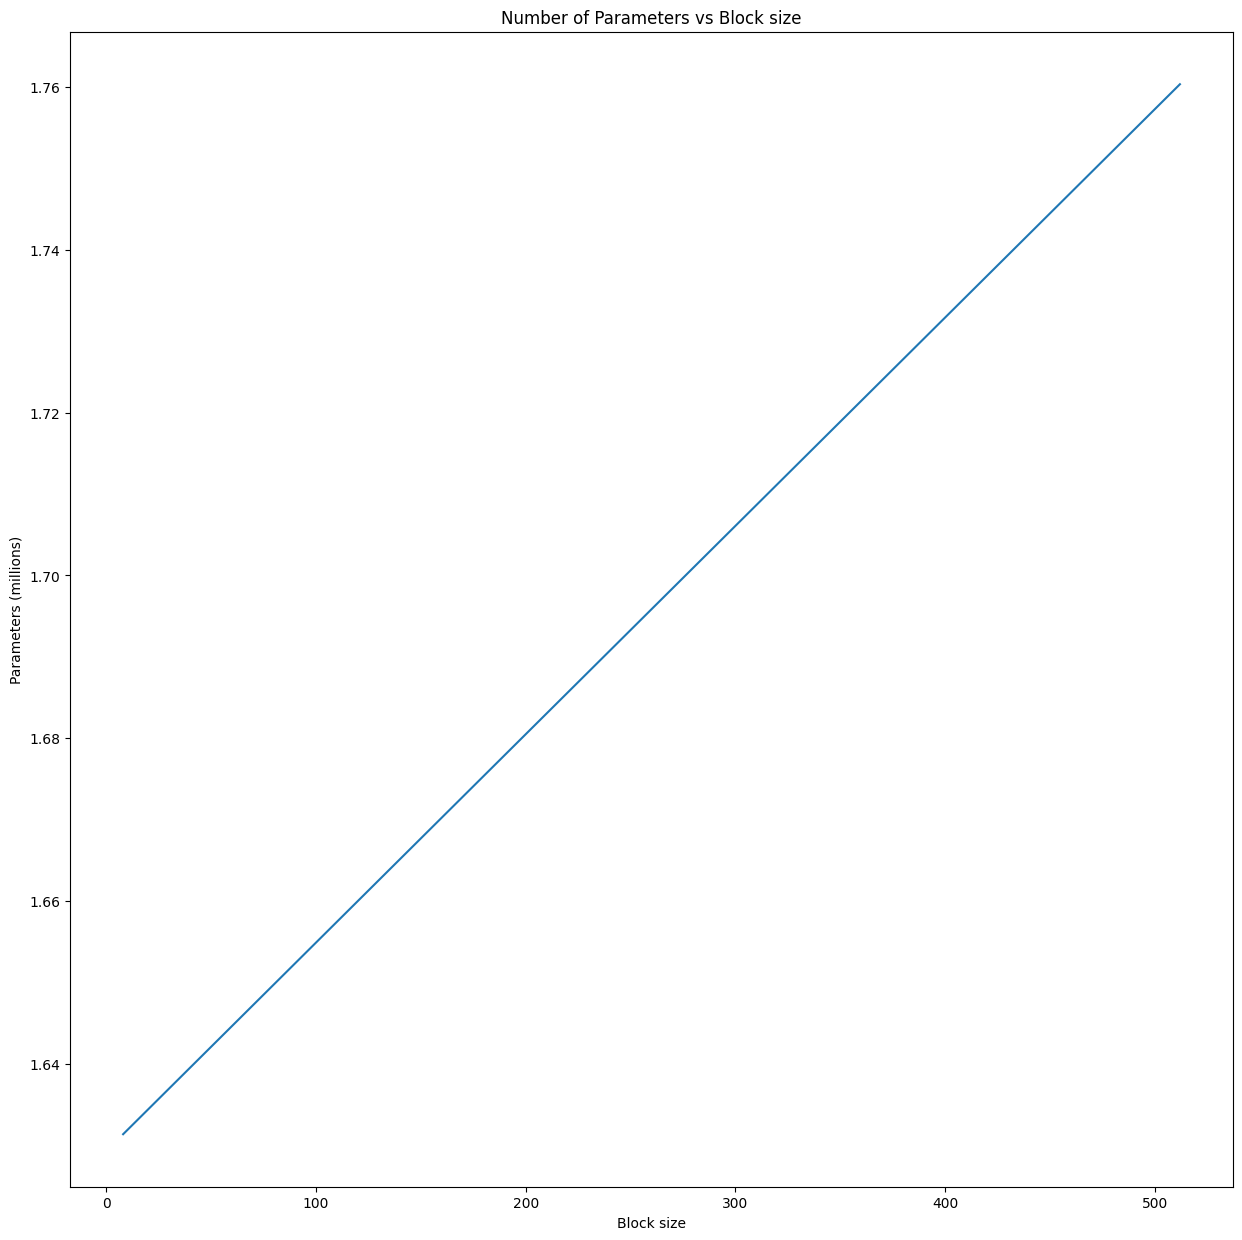

In [45]:
# Plot the number of parameters vs. block size (in multiples of 8, capped at 512)
block_size_params = {"x": list(), "y": list()}              # Initialise block_size_params with x and y containing empty lists
for block_size in range(8, 513, 8):                         # For each 8th block_size,
    cfg = Config(block_size=block_size)                     # Get Config according to block_size
    model = SastaGPT(cfg)                                   # Create an instance of SastaGPT accordingly
    block_size_params["x"].append(block_size)               # Append block_size to the list of x
    block_size_params["y"].append(get_params(model))        # Append number of parameters (in millions) to the list of y

plt.figure(figsize=(15, 15))                                # Initialise a figure of size (15, 15)
plt.plot(block_size_params["x"], block_size_params["y"])    # Plot x and y
plt.title("Number of Parameters vs Block size")
plt.xlabel("Block size")
plt.ylabel("Parameters (millions)")
plt.show()

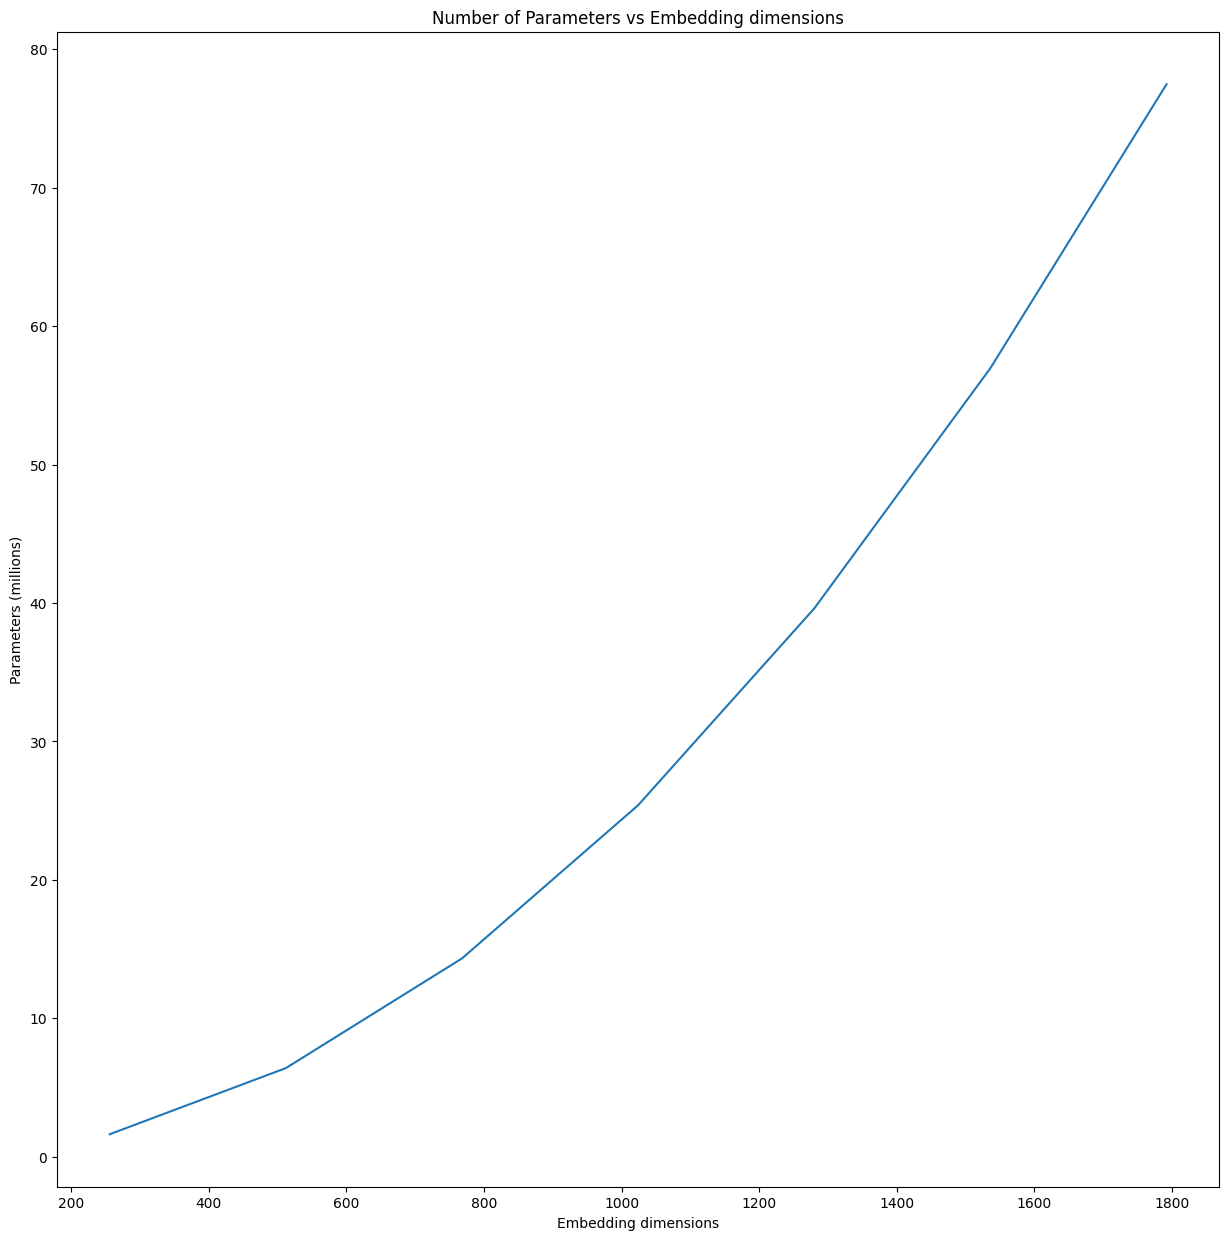

In [46]:
# Plot the number of parameters vs. embedding dimension (in multiples of 256, capped at 1792)
emb_dim_params = {"x": list(), "y": list()}                 # Initialise emb_dim_params with x and y containing empty lists
for emb_dim in range(256, 1793, 256):                       # For each 256th emb_dim,
    cfg = Config(emb_dim=emb_dim)                           # Get Config according to emb_dim
    model = SastaGPT(cfg)                                   # Create an instance of SastaGPT accordingly
    emb_dim_params["x"].append(emb_dim)                     # Append emb_dim to the list of x
    emb_dim_params["y"].append(get_params(model))           # Append number of parameters (in millions) to the list of y

plt.figure(figsize=(15, 15))                                # Initialise a figure of size (15, 15)
plt.plot(emb_dim_params["x"], emb_dim_params["y"])          # Plot x and y
plt.title("Number of Parameters vs Embedding dimensions")
plt.xlabel("Embedding dimensions")
plt.ylabel("Parameters (millions)")
plt.show()

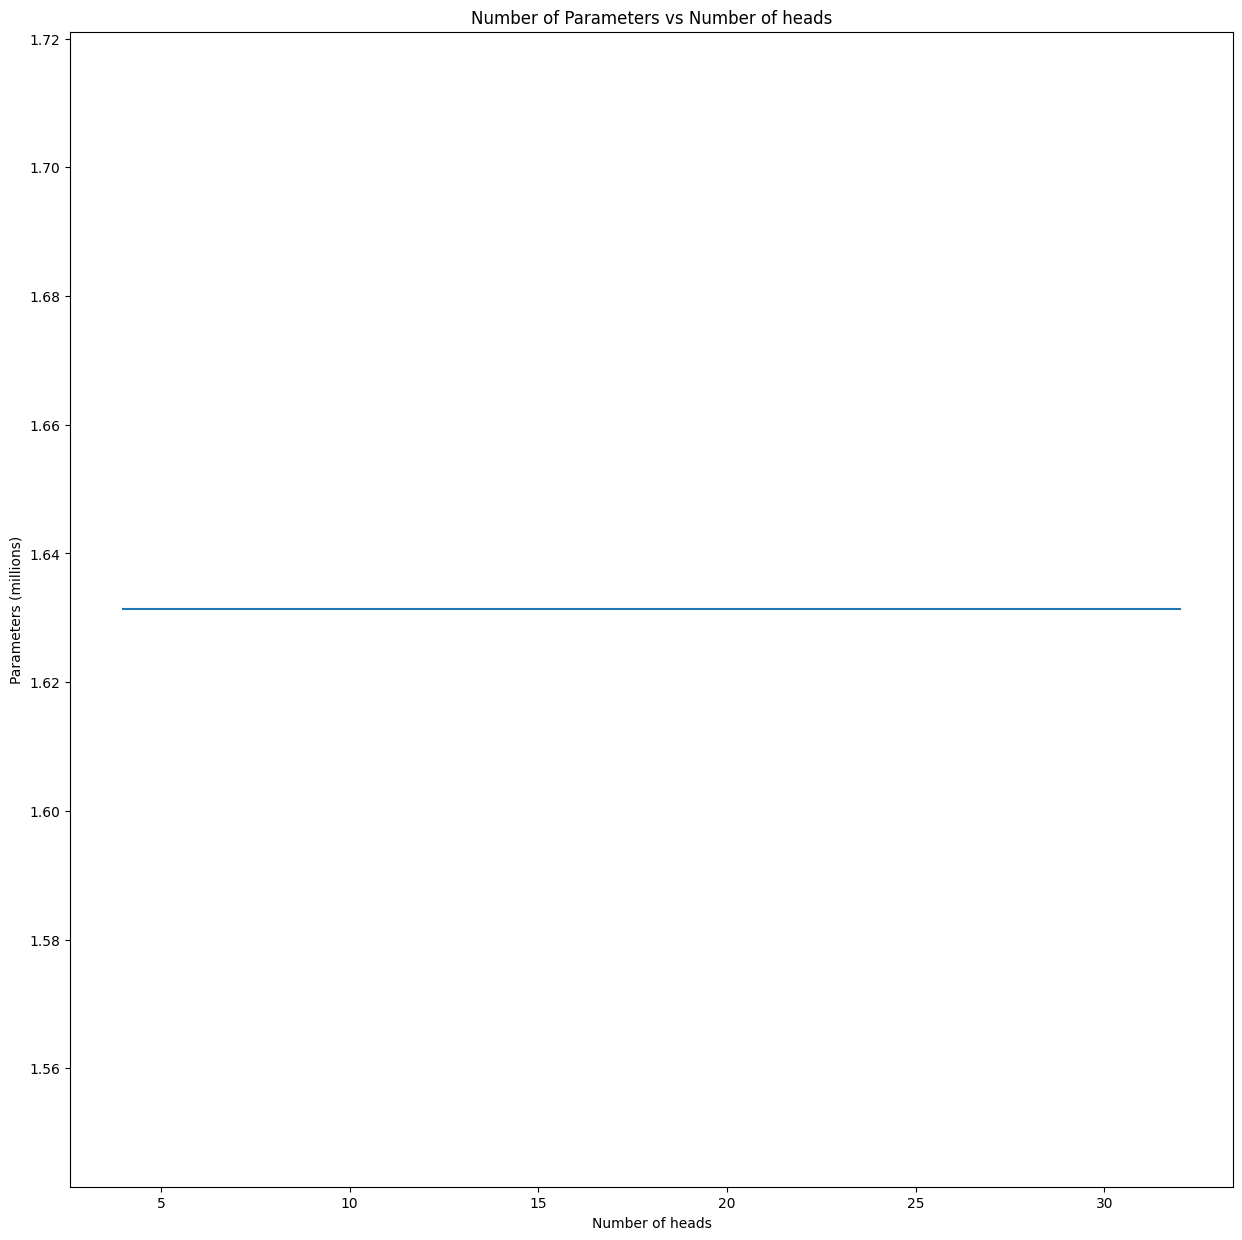

In [47]:
# Plot the number of parameters vs. number of heads (in multiples of 4, capped at 32)
num_heads_params = {"x": list(), "y": list()}               # Initialise num_heads_params with x and y containing empty lists
for num_heads in range(4, 33, 4):                           # For each 4th num_heads,
    cfg = Config(num_heads=num_heads)                       # Get Config according to num_heads
    model = SastaGPT(cfg)                                   # Create an instance of SastaGPT accordingly
    num_heads_params["x"].append(num_heads)                 # Append num_heads to the list of x
    num_heads_params["y"].append(get_params(model))         # Append number of parameters (in millions) to the list of y

plt.figure(figsize=(15, 15))                                # Initialise a figure of size (15, 15)
plt.plot(num_heads_params["x"], num_heads_params["y"])      # Plot x and y
plt.title("Number of Parameters vs Number of heads")
plt.xlabel("Number of heads")
plt.ylabel("Parameters (millions)")
plt.show()

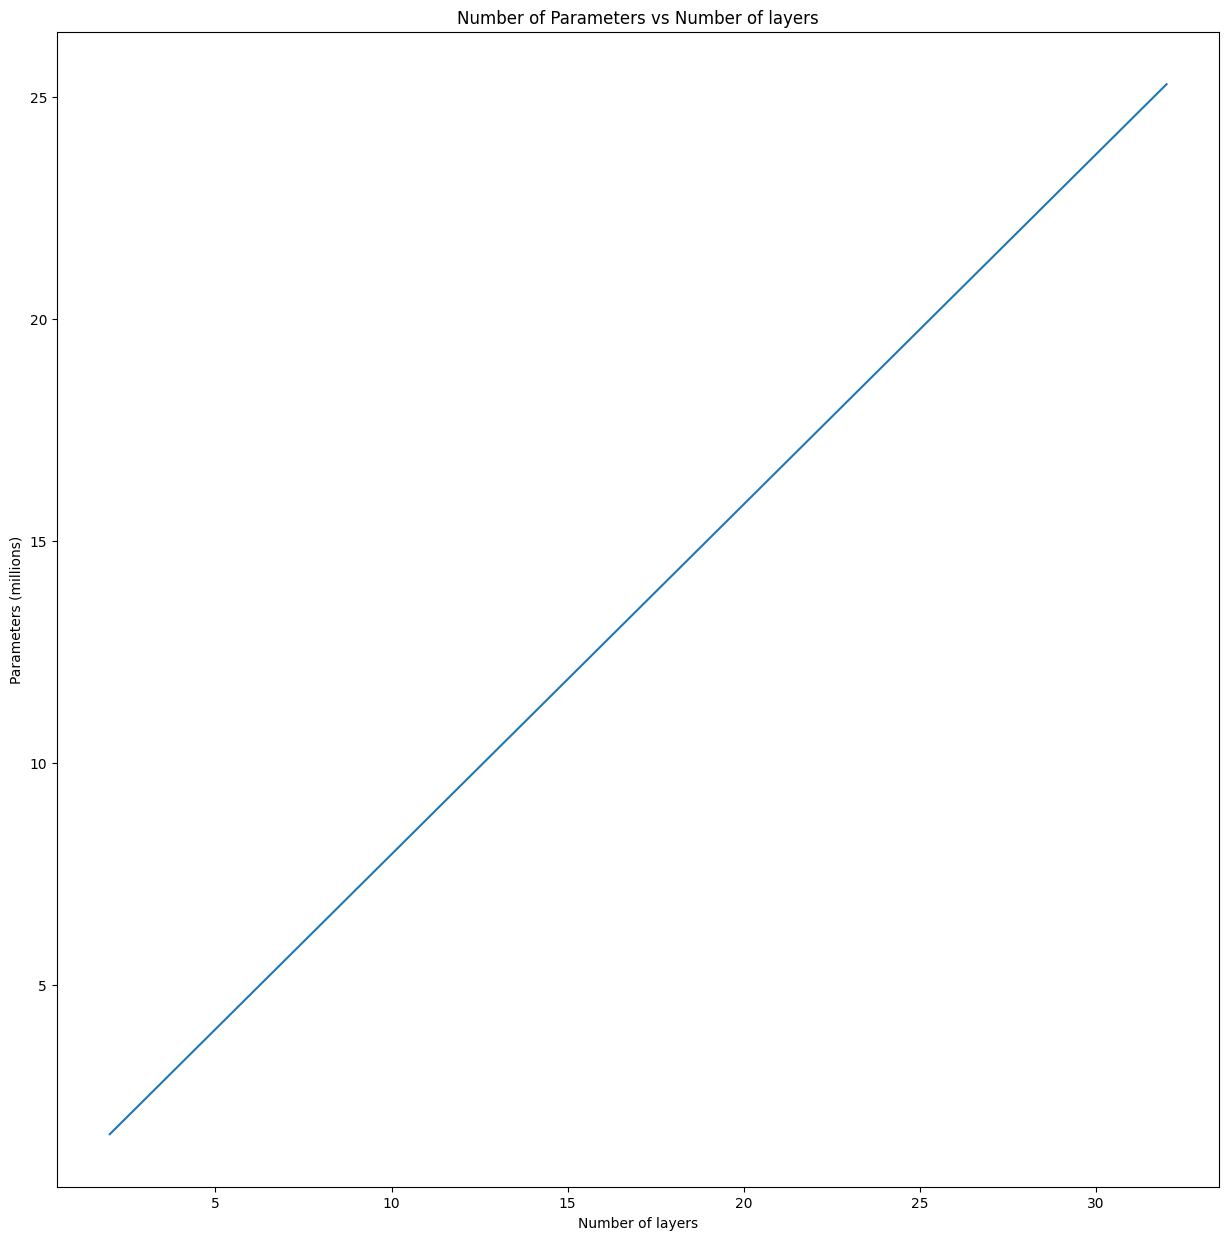

In [48]:
# Plot the number of parameters vs. number of layers
num_layers_params = {"x": list(), "y": list()}              # Initialise num_layers_params with x and y containing empty lists
for num_layers in range(2, 33, 2):                          # For each 2nd num_layers (randomly capped it at 32),
    cfg = Config(num_layers=num_layers)                     # Get Config according to num_layers
    model = SastaGPT(cfg)                                   # Create an instance of SastaGPT accordingly
    num_layers_params["x"].append(num_layers)               # Append num_layers to the list of x
    num_layers_params["y"].append(get_params(model))        # Append number of parameters (in millions) to the list of y

plt.figure(figsize=(15, 15))                                # Initialise a figure of size (15, 15)
plt.plot(num_layers_params["x"], num_layers_params["y"])    # Plot x and y
plt.title("Number of Parameters vs Number of layers")
plt.xlabel("Number of layers")
plt.ylabel("Parameters (millions)")
plt.show()

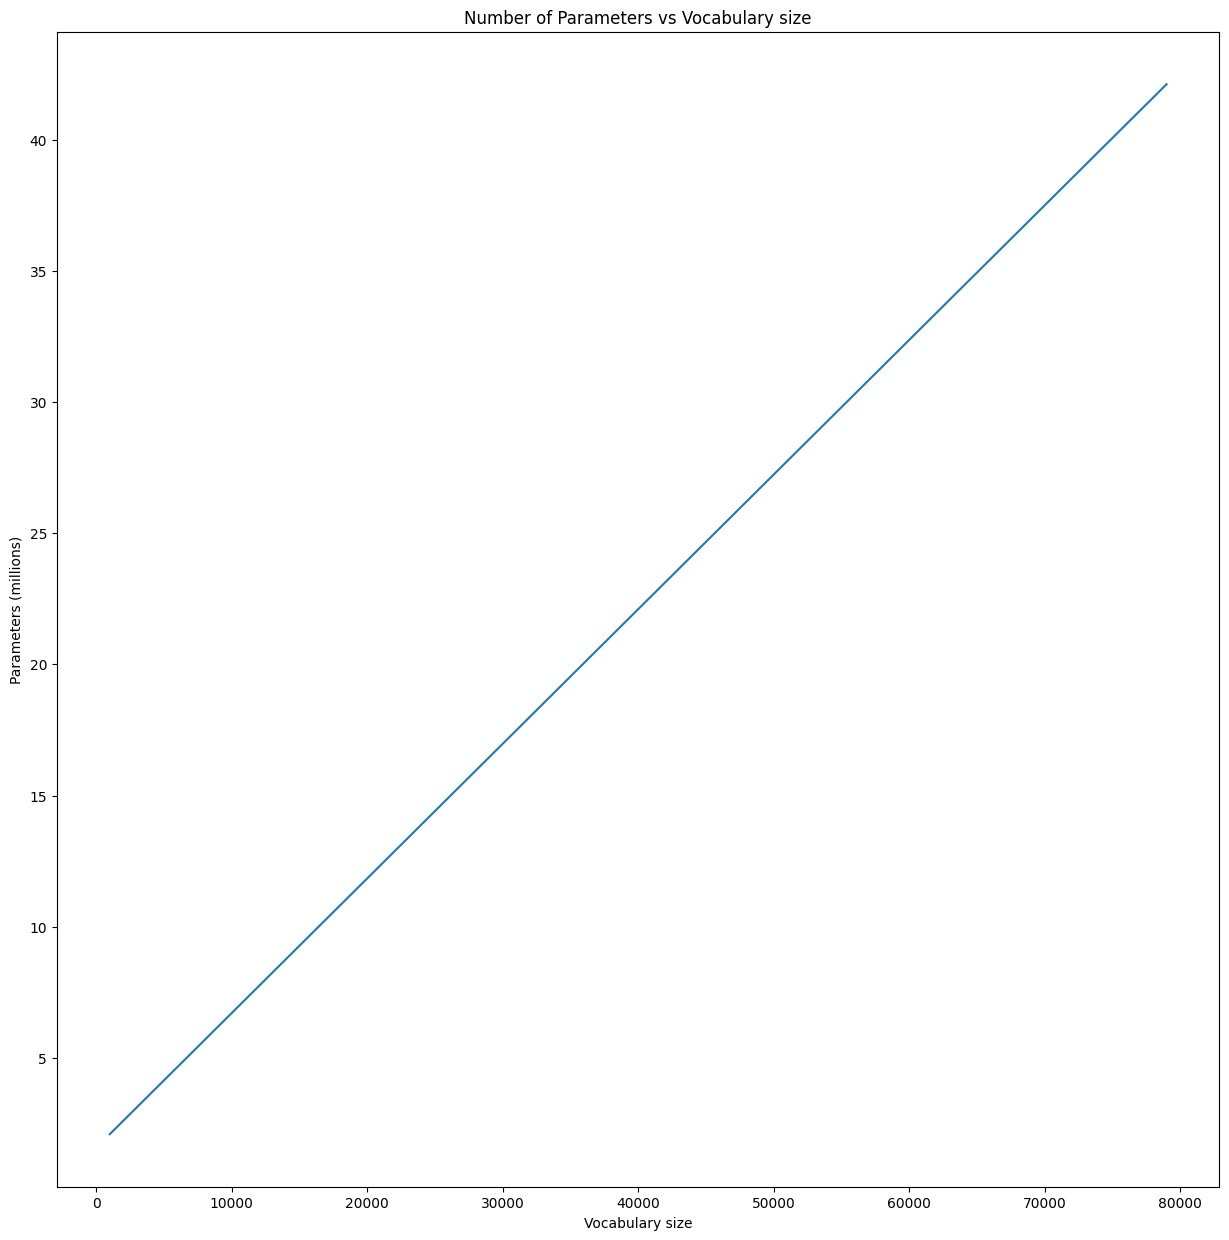

In [49]:
# Plot the number of parameters vs. vocabulary size
vocab_size_params = {"x": list(), "y": list()}              # Initialise vocab_size_params with x and y containing empty lists
for vocab_size in range(1000, 80000, 1000):                 # For each 1000th vocab_size (randomly capped it at 80000),
    cfg = Config(vocab_size=vocab_size)                     # Get Config according to vocab_size
    model = SastaGPT(cfg)                                   # Create an instance of SastaGPT accordingly
    vocab_size_params["x"].append(vocab_size)               # Append vocab_size to the list of x
    vocab_size_params["y"].append(get_params(model))        # Append number of parameters (in millions) to the list of y

plt.figure(figsize=(15, 15))                                # Initialise a figure of size (15, 15)
plt.plot(vocab_size_params["x"], vocab_size_params["y"])    # Plot x and y
plt.title("Number of Parameters vs Vocabulary size")
plt.xlabel("Vocabulary size")
plt.ylabel("Parameters (millions)")
plt.show()

As we can see, the number of layers is the most and number of heads have the least effect on the number of parameters.

# Fin.